# Model Comparison
Suppose we wanted to compare cell tracking results from two seperate models. We can do this with CoMET! We just need to define our config for the two models.

In [1]:
# This path append is just for testing from within the examples folder, no need for the user to add this
import sys
sys.path.append("..")

import yaml
import CoMET

CONFIG = CoMET.CoMET_load(CONFIG_string="""
wrf:
    path_to_data: "/D3/data/thahn/wrf/wrfout_2023_07_09/wrfout_d02*"

    feature_tracking_var: "dbz" #DBZ, TB, WA, PR
    segmentation_var: "dbz"

    tobac:
        feature_id:
            threshold: [40,50,60]
            target: "maximum"
            position_threshold: "weighted_diff"
            sigma_threshold: 0.5
            n_min_threshold: 4
        
        linking: 
            method_linking: "predict"
            adaptive_stop: 0.2
            adaptive_step: 0.95
            order: 1
            subnetwork_size: 10
            memory: 1
            v_max: 20
        
        segmentation_2d:
            height: 2000 # m
            method: "watershed"
            threshold: 30
            
        segmentation_3d:
            method: "watershed"
            threshold: 30
    
        analysis: # Optional
            eth: { variable: "DBZ", cell_footprint_height: 2000, threshold: 5 }
            area-low: { height: 2000 }
            area-high: { height: 4000 }
            volume: {}

mesonh:
    path_to_data: "/D3/data/thahn/MesoNH/CLN/0_5km/500m*"

    feature_tracking_var: "dbz" #DBZ, TB, WA
    segmentation_var: "dbz"

    tobac:
        feature_id:
            threshold: [10,20,30]
            target: "maximum"
            position_threshold: "weighted_diff"
            sigma_threshold: 0.5
            n_min_threshold: 4
        
        linking: 
            method_linking: "predict"
            adaptive_stop: 0.2
            adaptive_step: 0.95
            order: 1
            subnetwork_size: 10
            memory: 1
            v_max: 20
        
        segmentation_2d:
            height: 2000 # m
            method: "watershed"
            threshold: 5
            
        segmentation_3d:
            method: "watershed"
            threshold: 5
    
        analysis:
            eth: { variable: "DBZ", cell_footprint_height: 2000, threshold: 5 }
            area-low: { height: 2000 }
            area-high: { height: 4000 }
            volume: {}
""")

=====Welcome To CoMET=====

This project was supported by the U.S. Department of Energy (DOE) Early Career Research Program, Atmospheric System Research (ASR) program, and the Office of Workforce Development for Teachers and Scientists (WDTS) under the Science Undergraduate Laboratory Internships Program (SULI).

If you are using this software for a publication, please cite: ####


=====WRF Setup Found in CONFIG=====
=====MesoNH Setup Found in CONFIG=====


Then we can call CoMET_start to get our output

In [3]:
output = CoMET.CoMET_start(CONFIG=CONFIG)

=====Loading WRF Data=====
=====Starting WRF tobac Feature ID=====
=====Starting WRF tobac Feature Linking=====
=====Starting WRF tobac 2D Segmentation=====
=====Starting WRF tobac 3D Segmentation=====


=====Performing tobac Segmentation to UDAF=====: 100%|████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 74.51it/s]


=====Starting WRF tobac Analysis Calculations=====


=====Calculating Volumes=====: 100%|██████████████████████████████████████████████████████████████████████████| 51/51 [00:05<00:00,  8.70it/s]


=====Converting WRF tobac Output to CoMET-UDAF=====
=====WRF tobac Tracking Complete=====
=====Loading MesoNH Data=====
=====Starting MesoNH tobac Feature ID=====
=====Starting MesoNH tobac Feature Linking=====
=====Starting MesoNH tobac 2D Segmentation=====
=====Starting MesoNH tobac 3D Segmentation=====


=====Performing tobac Segmentation to UDAF=====: 100%|████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  8.38it/s]


=====Starting MesoNH tobac Analysis Calculations=====


=====Calculating Volumes=====: 100%|██████████████████████████████████████████████████████████████████████████| 46/46 [00:23<00:00,  1.96it/s]

=====Converting MesoNH tobac Output to CoMET-UDAF=====
=====MesoNH tobac Tracking Complete=====
=====CoMET Performance Diagonistics=====
$ Total Process Time: 1102.23 Seconds
$ Allocated Resources: Cores = 1


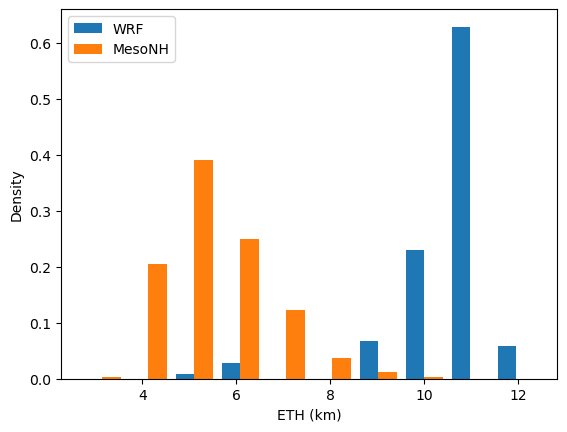

In [4]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()

ax.hist([output['wrf']['tobac']['analysis']['eth'].eth.values,output['mesonh']['tobac']['analysis']['eth'].eth.values],density=True,label=["WRF","MesoNH"])
ax.set_xlabel("ETH (km)")
ax.set_ylabel("Density")
ax.legend()
plt.show()